In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools
from permacache import stable_hash

In [4]:
from evallm.experiments.transducer_plotting import produce_table

from evallm.experiments.transducer_summary import prompt_by_key as prompts_t
from evallm.experiments.sequence_completion_summary import (
    prompts_by_key as prompts_s,
    current_setting as current_setting_s,
)

from evallm.experiments.exhaustive_transducer_experiment import (
    run_experiment_for_dfa,
    SummaryStats,
    compute_ngram_each,
)
from evallm.enumerate_dfa.pack_dfa import pack_dfa, unpack_dfa
from evallm.experiments.sequence_completion.sequence_completion_experiments import (
    run_model as run_model_sc,
    collate_model_responses as collate_model_responses_sc,
)
from evallm.experiments.sequence_completion.sample_sequences import (
    sample_task_instances_given_dfa,
)

from evallm.experiments.example import transducer_example_csv

# from evallm.prompting.transducer_prompt import BasicSequencePrompt, BasicSequencePromptNoChat

In [5]:
# chat_prompt = prompt_by_key["Basic"]["chat"]
# non_chat_prompt = prompt_by_key["Basic"]["non-chat"]

In [6]:
sum_dfa = unpack_dfa(
    pack_dfa(
        DFA(
            states={0, 1, 2},
            input_symbols={0, 1, 2},
            transitions={a: {b: (a + b) % 3 for b in range(3)} for a in range(3)},
            initial_state=0,
            final_states={0},
        )
    )
)

sequence_tasks = sample_task_instances_given_dfa(
    np.random.RandomState(0),
    num_sequences=current_setting_s["num_sequences"],
    num_sequence_symbols=current_setting_s["num_sequence_symbols"],
    num_sequence_symbols_prompt=current_setting_s["num_sequence_symbols_prompt"],
    try_limit=50,
    num_instances=1000,
    dfa=sum_dfa,
)

In [7]:
res_claude = run_experiment_for_dfa(
    prompts_t["Red-Green"]["chat"],
    pack_dfa(sum_dfa),
    1000,
    "claude-3-5-sonnet-20241022",
    0,
    keep_completions=True,
)

In [8]:
res_qwen = run_experiment_for_dfa(
    prompts_t["Basic"]["non-chat"], pack_dfa(sum_dfa), 1000, "Qwen/Qwen2.5-Coder-7B", 0
)

In [9]:
from matplotlib_venn import venn3

In [10]:
transducer_masks = {
    "claude": res_claude.accuracy_each,
    "qwen": res_qwen.accuracy_each,
    "6gram": compute_ngram_each(res_qwen)[:, 6 - 2],
}

In [11]:
blue = "#009bff"
green = "#26d94a"
red = "#ff0062"

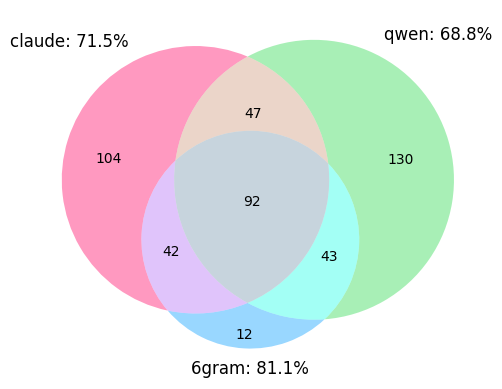

In [12]:
venn3(
    subsets=[set(np.where(x == 0)[0]) for x in transducer_masks.values()],
    set_labels=[f"{k}: {v.mean():.1%}" for k, v in transducer_masks.items()],
    set_colors=(red, green, blue),
)

In [13]:
def random_samples_each(masks, size=30):
    rng = np.random.RandomState(0)
    return {k: rng.choice(np.where(masks[k])[0], size=size) for k in masks}

In [14]:
masks_t = {
    "claude-correct": transducer_masks["claude"] == 1,
    "claude-incorrect-6gram-correct": (transducer_masks["claude"] == 0)
    & (transducer_masks["6gram"] == 1),
    "both-incorrect": (transducer_masks["claude"] == 0)
    & (transducer_masks["6gram"] == 0),
}
samples_t = random_samples_each(masks_t)

In [15]:
! mkdir -p output/example_dfa

In [16]:
transducer_example_csv(res_claude, samples_t).to_csv(
    "output/example_dfa/transducer_claude_sample.csv"
)

In [17]:
# run_model_sc(
#     "Qwen/Qwen2.5-Coder-7B",
#     prompts_s["Basic"](current_setting_s),
#     sum_dfa,
#     sequence_tasks,
# )

In [18]:
# run_model_sc(
#     "claude-3-5-sonnet-20241022",
#     prompts_s["COT"](current_setting_s),
#     sum_dfa,
#     sequence_tasks,
# )